In [1]:
import numpy as np
from scipy import signal
import xml.etree.ElementTree as ET
import os, sys
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import math

import matplotlib.cm as cm
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import load_model
import random


2024-11-26 12:14:21.267780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 12:14:21.277811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 12:14:21.289481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 12:14:21.292603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 12:14:21.301330: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.0


In [3]:
tf.config.experimental.list_physical_devices('GPU')

I0000 00:00:1732623263.847773   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732623263.858615   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732623263.858671   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


I0000 00:00:1732623265.354228   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732623265.354316   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732623265.354334   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732623266.268442   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732623266.268518   26300 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26

True

In [16]:
groups = ["group1A","group1B","group2A","group2B","group3"]
GRs = ["G1A","G1B","G2A","G2B","G3"]
def getKinectPath(row):
	group = groups[GRs.index(row["Group"])]
	
	if group in ["group1B","group2B"]:
		filename = '-'.join([row["Group"],'Kinect',row["Exercise"],row["Place"],"{:03d}".format(row["Record"])]) +'.txt'
	else:
		filename = '-'.join([row["Group"],'Kinect',row["Exercise"],row["Patient"],row["Place"],"{:03d}".format(row["Record"])]) +'.txt'

	return '/'.join([group,'kinect',filename])
	

errorNameList = ['Correct','Error1','Error2','Error3','Incomplete','Motionless']
def getAnnotationA(row):
	return errorNameList.index(row['annotatorA']) if row['annotatorA'] in errorNameList else 0

def getAnnotationB(row):
	return errorNameList.index(row['annotatorB']) if row['annotatorB'] in errorNameList else 0

def load_dataset(dfTrain, dfTest, padding):
	# train
	x_train_list=[]
	y_train_list=[]

	pathTrain = dfTrain.apply(getKinectPath, axis=1).tolist()
	annotationA_train = dfTrain.apply(getAnnotationA, axis=1).tolist()
	annotationB_train = dfTrain.apply(getAnnotationB, axis=1).tolist()

	for i in range(len(pathTrain)):
		data = load_skeleton_data_processed(pathTrain[i])
		data = interpolate(data,padding)
		x_train_list.append(data)
		y_train_list.append(annotationA_train[i])
		if (annotationA_train[i] != annotationB_train[i]):
			x_train_list.append(data)
			y_train_list.append(annotationB_train[i])
	
	# x_train_list = np.asarray(paddingArray(x_train_list,padding))
	# x_train_list = np.asarray(interpolate(x_train_list,padding))
	x_train_list = np.asarray(x_train_list)
	y_train_list = np.asarray(y_train_list)

	# test
	x_test_list=[]
	y_test_list=[]

	pathTest = dfTest.apply(getKinectPath, axis=1).tolist()
	annotationA_test = dfTest.apply(getAnnotationA, axis=1).tolist()
	annotationB_test= dfTest.apply(getAnnotationB, axis=1).tolist()

	for i in range(len(pathTest)):
		data = load_skeleton_data_processed(pathTest[i])
		data = interpolate(data,padding)
		x_test_list.append(data)
		y_test_list.append(annotationA_test[i])
		if (annotationA_test[i] != annotationB_test[i]):
			x_test_list.append(data)
			y_test_list.append(annotationB_test[i])
	
	# x_test_list = np.asarray(paddingArray(x_test_list,padding))
	x_test_list = np.asarray(x_test_list)
	y_test_list = np.asarray(y_test_list)

	return x_train_list,y_train_list,x_test_list,y_test_list

def load_skeleton_data_processed(path):
	data = np.genfromtxt(path, delimiter=' ', filling_values=np.nan)
	return data

def paddingArray(data, padding):
	# Find the maximum number of rows in the data
	max_rows = padding

	# Pad or truncate each array in the list to have the same number of rows
	data_padded = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, 0)), mode='constant', constant_values=0) for arr in data]
	return data_padded

def interpolate(data, max_rows):
	df = pd.DataFrame(data)
	# Repeat the last row until reaching max_rows
	while len(df) < max_rows:
		last_row = df.iloc[-1]
		df = pd.concat([df, pd.DataFrame([last_row], columns=df.columns)], ignore_index=True)
	return df.to_numpy()
	# interpolated_df = df.reindex(range(max_rows)).interpolate(method='linear')
	# return interpolated_df.to_numpy()


In [6]:
data = load_skeleton_data_processed("group1A/kinect/G1A-Kinect-CTK-R1-Brest-022.txt")
print(data.shape)

(300, 175)


In [7]:
data_i = interpolate(data, 900)

In [8]:
print(data_i.shape)

(900, 175)


In [9]:
class LSTM_CLASSIF:

    def __init__(self, input_shape, num_layers, neurons, build=True,output_shape=4):
        self.neurons = neurons
        self.output_shape = output_shape

        if build == True:
            self.model = self.build_model(input_shape, num_layers, neurons)
            self.model.summary()

    def build_model(self, input_shape, num_layers, neurons):
        inputs = tf.keras.layers.Input(input_shape, name='inputs')

        # lstm layers, intermediate layers return sequences of hidden states, last layer returns last hidden state only
        if num_layers>1:
            # first lstm layer
            lstm_enc_output = tf.keras.layers.LSTM(neurons, name='lstm_enc_1', return_sequences=True)(inputs)
            # other lstm layers if num_layers>1
            for l in range(2,num_layers):
                name_layer = 'lstm_enc_' + str(l)
                lstm_enc_output = tf.keras.layers.LSTM(neurons, name=name_layer, return_sequences=True)(lstm_enc_output)
            # last layer (return last hidden state)
            name_layer = 'lstm_enc_' + str(num_layers)
            lstm_enc_output = tf.keras.layers.LSTM(neurons, name=name_layer, return_sequences=False)(lstm_enc_output)
        else:
            lstm_enc_output = tf.keras.layers.LSTM(neurons, name='lstm_enc_1', return_sequences=False)(inputs)

        outputs = tf.keras.layers.Dense(self.output_shape,activation='softmax')(lstm_enc_output)
        
        model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(1e-3)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model
        
    def fit(self, x_train, y_train, batch_size, nb_epochs):
        hist = self.model.fit(x_train,y_train, batch_size=batch_size, epochs=nb_epochs, verbose=True)
        return hist

    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return y_pred

    def evaluate(self, x_test, y_true):
        loss, acc = self.model.evaluate(x_test,y_true)
        return loss, acc
    
    def save(self, path):
        self.model.save(path)


In [32]:
df = pd.read_csv("keraalTable.csv")
df

,Group,Exercise,Patient,Place,Record,BlazePose,Kinect,OpenPose,annotatorA,annotatorB
0,G1A,CTK,R1,Brest,22,300.0,300.0,301.0,Error1,Error1
1,G1A,CTK,R1,Brest,38,328.0,328.0,329.0,Correct,Correct
2,G1A,CTK,R1,Brest,42,318.0,318.0,319.0,Error1,Error1
3,G1A,CTK,R1,Brest,54,305.0,305.0,306.0,Error1,Error1
4,G1A,CTK,R1,Brest,56,298.0,298.0,299.0,Error1,Error1
...,...,...,...,...,...,...,...,...,...,...
2616,G3,RTK,P3T3,Unknown-E3B3,0,211.0,212.0,212.0,NaN,NaN
2617,G3,RTK,P3T3,Unknown-E3B3,1,214.0,213.0,215.0,NaN,NaN
2618,G3,RTK,P3T3,Unknown-E3B3,2,211.0,212.0,212.0,NaN,NaN
2619,G3,RTK,P3T3,Unknown-E3B3,3,214.0,213.0,215.0,NaN,NaN


In [11]:
df = df[df['Group'].isin(['G1A', 'G2A'])]
df

,Group,Exercise,Patient,Place,Record,BlazePose,Kinect,OpenPose,annotatorA,annotatorB
0,G1A,CTK,R1,Brest,22,300.0,300.0,301.0,Error1,Error1
1,G1A,CTK,R1,Brest,38,328.0,328.0,329.0,Correct,Correct
2,G1A,CTK,R1,Brest,42,318.0,318.0,319.0,Error1,Error1
3,G1A,CTK,R1,Brest,54,305.0,305.0,306.0,Error1,Error1
4,G1A,CTK,R1,Brest,56,298.0,298.0,299.0,Error1,Error1
...,...,...,...,...,...,...,...,...,...,...
1927,G2A,RTK,S5,Brest,74,312.0,312.0,313.0,Correct,Correct
1928,G2A,RTK,S6,Roscoff,42,416.0,416.0,417.0,Motionless,Error1
1929,G2A,RTK,S6,Roscoff,62,415.0,423.0,424.0,Error1,Error1
1930,G2A,RTK,S6,Roscoff,71,408.0,408.0,409.0,Error1,Error1


In [12]:
print(max(df["Kinect"]))

871.0


In [13]:
dfCTK = df[df['Exercise']=='CTK']
dfELK = df[df['Exercise']=='ELK']
dfRTK = df[df['Exercise']=='RTK']
# Reset index for dfCTK
dfCTK = dfCTK.reset_index(drop=True)

# Reset index for dfELK
dfELK = dfELK.reset_index(drop=True)

# Reset index for dfRTK
dfRTK = dfRTK.reset_index(drop=True)

In [24]:
df_sub = dfCTK
pad = 871
df_sub1 = df_sub[df_sub['Group']=='G1A']
df_sub2 = df_sub[df_sub['Group']=='G2A']

train_df_sub1, test_df_sub1 = train_test_split(df_sub1, test_size=0.2, random_state=42)
train_df_sub2, test_df_sub2 = train_test_split(df_sub2, test_size=0.2, random_state=42)

df_subTrain = pd.concat([train_df_sub1, train_df_sub2], ignore_index=True)
df_subTest = pd.concat([test_df_sub1, test_df_sub2], ignore_index=True)

# load_skeleton_data_processed(path)

x_train,y_train,x_test,y_multi = load_dataset(df_subTrain,df_subTest, pad)
# print(x_train.shape, y_train.shape, x_test.shape, y_multi.shape)


# keep only test samples that are correct or one of the 3 errors (y<4)
x_test = x_test[np.where(y_multi<4),:,:][0]
y_multi = y_multi[np.where(y_multi<4),][0]

# modidy labels to one-hot vectors
y_train_test = np.concatenate((y_train,y_multi),axis =0)
encoder = LabelEncoder()
new_y_train_test = encoder.fit_transform(y_train_test)
encoder = OneHotEncoder(categories=[range(6)])
new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))
new_y_train = new_y_train_test[0:len(y_train)].toarray()
new_y_test = new_y_train_test[len(y_train):].toarray()
# print('new_y_train',new_y_train.shape) 
# print('new_y_test',new_y_test.shape)

input_shape=x_train.shape[1:]
print(input_shape)

neurons=512
num_layers=3

model = LSTM_CLASSIF(input_shape, num_layers, neurons=neurons,output_shape=6)

batch_size = 32
num_epochs = 100

hist = model.fit(x_train,new_y_train,batch_size,num_epochs)

loss, acc = model.evaluate(x_test,new_y_test)
name = df_sub["Exercise"][0]
print(name)
print(loss)
print(acc)

model.save("model_LSTM_classifer_"+name+".keras")

del model

(871, 175)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 871, 175)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_1 (LSTM)               │ (None, 871, 512)       │     1,409,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_2 (LSTM)               │ (None, 871, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_3 (LSTM)               │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,610,502 (21.40 MB)

 Trainable params: 5,610,502 (21.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.3123 - loss: 2.0474
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.5337 - loss: 1.6287
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.4609 - loss: 1.2601
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.3180 - loss: 1.2872
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 419ms/step - accuracy: 0.5212 - loss: 1.2367
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.5150 - loss: 1.1794
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5400 - loss: 1.1973
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.5223 - loss: 1.2274
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.5358 - loss: 1.2125
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.5004 - loss: 1.2513
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.5306 - loss: 1.2178
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy:

In [28]:
df_sub = dfELK
pad = 871
df_sub1 = df_sub[df_sub['Group']=='G1A']
df_sub2 = df_sub[df_sub['Group']=='G2A']

train_df_sub1, test_df_sub1 = train_test_split(df_sub1, test_size=0.2, random_state=42)
train_df_sub2, test_df_sub2 = train_test_split(df_sub2, test_size=0.2, random_state=42)

df_subTrain = pd.concat([train_df_sub1, train_df_sub2], ignore_index=True)
df_subTest = pd.concat([test_df_sub1, test_df_sub2], ignore_index=True)

# load_skeleton_data_processed(path)

x_train,y_train,x_test,y_multi = load_dataset(df_subTrain,df_subTest, pad)
# print(x_train.shape, y_train.shape, x_test.shape, y_multi.shape)


# keep only test samples that are correct or one of the 3 errors (y<4)
x_test = x_test[np.where(y_multi<4),:,:][0]
y_multi = y_multi[np.where(y_multi<4),][0]

# modidy labels to one-hot vectors
y_train_test = np.concatenate((y_train,y_multi),axis =0)
encoder = LabelEncoder()
new_y_train_test = encoder.fit_transform(y_train_test)
encoder = OneHotEncoder(categories=[range(6)])
new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))
new_y_train = new_y_train_test[0:len(y_train)].toarray()
new_y_test = new_y_train_test[len(y_train):].toarray()
# print('new_y_train',new_y_train.shape) 
# print('new_y_test',new_y_test.shape)

input_shape=x_train.shape[1:]
print(input_shape)

neurons=512
num_layers=3

model = LSTM_CLASSIF(input_shape, num_layers, neurons=neurons,output_shape=6)

batch_size = 32
num_epochs = 100

hist = model.fit(x_train,new_y_train,batch_size,num_epochs)

loss, acc = model.evaluate(x_test,new_y_test)
name = df_sub["Exercise"][0]
print(name)
print(loss)
print(acc)

model.save("model_LSTM_classifer_"+name+".keras")

del model

(871, 175)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 871, 175)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_1 (LSTM)               │ (None, 871, 512)       │     1,409,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_2 (LSTM)               │ (None, 871, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_3 (LSTM)               │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,610,502 (21.40 MB)

 Trainable params: 5,610,502 (21.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.5445 - loss: 2.1221
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.3849 - loss: 1.5916
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.4955 - loss: 1.1599
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 0.3646 - loss: 1.1085
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 0.5236 - loss: 1.0676
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.5275 - loss: 1.0986
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.5314 - loss: 1.0489
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - accuracy: 0.5314 - loss: 1.0038
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.5431 - loss: 1.0517
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5431 - loss: 1.0275
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.5353 - loss: 1.0477
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - accuracy:

In [30]:
df_sub = dfRTK
pad = 871
df_sub1 = df_sub[df_sub['Group']=='G1A']
df_sub2 = df_sub[df_sub['Group']=='G2A']

train_df_sub1, test_df_sub1 = train_test_split(df_sub1, test_size=0.2, random_state=42)
train_df_sub2, test_df_sub2 = train_test_split(df_sub2, test_size=0.2, random_state=42)

df_subTrain = pd.concat([train_df_sub1, train_df_sub2], ignore_index=True)
df_subTest = pd.concat([test_df_sub1, test_df_sub2], ignore_index=True)

# load_skeleton_data_processed(path)

x_train,y_train,x_test,y_multi = load_dataset(df_subTrain,df_subTest, pad)
# print(x_train.shape, y_train.shape, x_test.shape, y_multi.shape)


# keep only test samples that are correct or one of the 3 errors (y<4)
x_test = x_test[np.where(y_multi<4),:,:][0]
y_multi = y_multi[np.where(y_multi<4),][0]

# modidy labels to one-hot vectors
y_train_test = np.concatenate((y_train,y_multi),axis =0)
encoder = LabelEncoder()
new_y_train_test = encoder.fit_transform(y_train_test)
encoder = OneHotEncoder(categories=[range(6)])
new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))
new_y_train = new_y_train_test[0:len(y_train)].toarray()
new_y_test = new_y_train_test[len(y_train):].toarray()
# print('new_y_train',new_y_train.shape) 
# print('new_y_test',new_y_test.shape)

input_shape=x_train.shape[1:]
print(input_shape)

neurons=512
num_layers=3

model = LSTM_CLASSIF(input_shape, num_layers, neurons=neurons,output_shape=6)

batch_size = 32
num_epochs = 100

hist = model.fit(x_train,new_y_train,batch_size,num_epochs)

loss, acc = model.evaluate(x_test,new_y_test)
name = df_sub["Exercise"][0]
print(name)
print(loss)
print(acc)

model.save("model_LSTM_classifer_"+name+".keras")

del model

(871, 175)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 871, 175)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_1 (LSTM)               │ (None, 871, 512)       │     1,409,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_2 (LSTM)               │ (None, 871, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_3 (LSTM)               │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,610,502 (21.40 MB)

 Trainable params: 5,610,502 (21.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.4950 - loss: 1.8684
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5820 - loss: 1.4296 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.6310 - loss: 1.0374
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.6622 - loss: 1.0183
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.6507 - loss: 1.0335
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5945 - loss: 1.0759
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.6594 - loss: 0.9083
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.6615 - loss: 0.8959
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.6192 - loss: 1.0261
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.6139 - loss: 0.9397
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.6372 - loss: 0.9504
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy:

In [ ]:
# pad = 871
# for df_sub, output_shape in zip([dfCTK,dfELK,dfRTK],[6,6,6]):
#     df_sub1 = df_sub[df_sub['Group']=='G1A']
#     df_sub2 = df_sub[df_sub['Group']=='G2A']

#     train_df_sub1, test_df_sub1 = train_test_split(df_sub1, test_size=0.2, random_state=42)
#     train_df_sub2, test_df_sub2 = train_test_split(df_sub2, test_size=0.2, random_state=42)

#     df_subTrain = pd.concat([train_df_sub1, train_df_sub2], ignore_index=True)
#     df_subTest = pd.concat([test_df_sub1, test_df_sub2], ignore_index=True)

#     # load_skeleton_data_processed(path)

#     x_train,y_train,x_test,y_multi = load_dataset(df_subTrain,df_subTest, pad)
#     # print(x_train.shape, y_train.shape, x_test.shape, y_multi.shape)


#     # keep only test samples that are correct or one of the 3 errors (y<4)
#     x_test = x_test[np.where(y_multi<4),:,:][0]
#     y_multi = y_multi[np.where(y_multi<4),][0]

#     # modidy labels to one-hot vectors
#     y_train_test = np.concatenate((y_train,y_multi),axis =0)
#     encoder = LabelEncoder()
#     new_y_train_test = encoder.fit_transform(y_train_test)
#     encoder = OneHotEncoder(categories=[range(6)])
#     new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))
#     new_y_train = new_y_train_test[0:len(y_train)].toarray()
#     new_y_test = new_y_train_test[len(y_train):].toarray()
#     # print('new_y_train',new_y_train.shape) 
#     # print('new_y_test',new_y_test.shape)

#     input_shape=x_train.shape[1:]
#     print(input_shape)

#     neurons=512
#     num_layers=3

#     model = LSTM_CLASSIF(input_shape, num_layers, neurons=neurons,output_shape=output_shape)

#     batch_size = 32
#     num_epochs = 100

#     hist = model.fit(x_train,new_y_train,batch_size,num_epochs)

#     loss, acc = model.evaluate(x_test,new_y_test)
#     name = df_sub["Exercise"][0]
#     print(name)
#     print(loss)
#     print(acc)

#     model.save("model_LSTM_classifer_"+name+".keras")

#     del model


In [31]:


model = load_model('model_LSTM_classifer_CTK.keras')
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 871, 175)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_1 (LSTM)               │ (None, 871, 512)       │     1,409,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_2 (LSTM)               │ (None, 871, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_enc_3 (LSTM)               │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,831,508 (64.21 MB)

 Trainable params: 5,610,502 (21.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,221,006 (42.80 MB)

In [13]:
pad = 871

In [14]:
dfCTK = dfCTK[dfCTK['Group']=='G1B']

In [15]:
x_train,y_train,x_test,y_multi = load_dataset(dfCTK,dfCTK, pad)
x_test.shape

(1067, 871, 175)

In [16]:
result = model.predict(x_test)


2024-11-26 12:02:35.272726: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step


In [17]:
result.shape

(1067, 5)

In [18]:
# modidy labels to one-hot vectors
y_train_test = np.concatenate((y_train,y_multi),axis =0)
encoder = LabelEncoder()
new_y_train_test = encoder.fit_transform(y_train_test)
encoder = OneHotEncoder()
new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))
new_y_train = new_y_train_test[0:len(y_train)].toarray()
new_y_test = new_y_train_test[len(y_train):].toarray()

new_y_test.shape

(1067, 6)

In [ ]:
predicted, origin = predict_error(model,dfCTK)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Assuming y_train and y_multi are the original labels

# Inverse transform one-hot encoded labels back to label indices using the OneHotEncoder
# encoder = OneHotEncoder()
decoded_labels = encoder.inverse_transform(result)

# Inverse transform label indices back to original labels using the LabelEncoder
encoder = LabelEncoder()
decoded_labels = encoder.fit_transform(decoded_labels.reshape(-1, 1))

decoded_labels

ValueError: Shape of the passed X data is not correct. Expected 1 columns, got 5.

In [26]:
predicted_result = decoded_labels.tolist()
true_result = y_multi

print(len(predicted_result))
print(len(true_result))


131
131


In [27]:
df_result = pd.DataFrame(list(zip(predicted_result, true_result)), columns=['Predict', 'True'])
df_result

,Predict,True
0,1,1
1,0,0
2,1,1
3,1,1
4,1,1
...,...,...
126,0,0
127,0,0
128,4,4
129,0,0


In [31]:
count = 0
for index, row in df_result.iterrows():
    if row['Predict'] != row['True']:
        print(f"Row index: {index}")
        print(row)
        count+=1
print(count)

Row index: 9
Predict    1
True       2
Name: 9, dtype: int64
Row index: 16
Predict    1
True       3
Name: 16, dtype: int64
Row index: 20
Predict    0
True       1
Name: 20, dtype: int64
Row index: 21
Predict    0
True       3
Name: 21, dtype: int64
Row index: 24
Predict    3
True       1
Name: 24, dtype: int64
Row index: 25
Predict    1
True       3
Name: 25, dtype: int64
Row index: 27
Predict    0
True       1
Name: 27, dtype: int64
Row index: 29
Predict    1
True       4
Name: 29, dtype: int64
Row index: 34
Predict    0
True       1
Name: 34, dtype: int64
Row index: 37
Predict    1
True       0
Name: 37, dtype: int64
Row index: 40
Predict    0
True       1
Name: 40, dtype: int64
Row index: 42
Predict    0
True       1
Name: 42, dtype: int64
Row index: 43
Predict    1
True       3
Name: 43, dtype: int64
Row index: 46
Predict    1
True       3
Name: 46, dtype: int64
Row index: 50
Predict    1
True       3
Name: 50, dtype: int64
Row index: 54
Predict    0
True       1
Name: 54, dtype: 

In [34]:
def predict_error(model,data, pad=871):
    x_train,y_train,x_test,y_multi = load_dataset(data,data, pad)
    # modidy labels to one-hot vectors
    y_train_test = np.concatenate((y_train,y_multi),axis =0)
    encoder = LabelEncoder()
    new_y_train_test = encoder.fit_transform(y_train_test)
    encoder = OneHotEncoder(categories=[range(6)])
    new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))

    result = model.predict(x_test)

    # Assuming y_train and y_multi are the original labels

    # Inverse transform one-hot encoded labels back to label indices using the OneHotEncoder
    decoded_labels = encoder.inverse_transform(result)

    # Inverse transform label indices back to original labels using the LabelEncoder
    encoder = LabelEncoder()
    decoded_labels = encoder.fit_transform(decoded_labels.reshape(-1, 1))

    decoded_labels

    predicted_result = decoded_labels.tolist()
    true_result = y_multi

    return predicted_result, true_result

In [35]:
df = df[df['Group'].isin(['G1B','G2B'])]

In [36]:
dfCTK = df[df['Exercise']=='CTK']
dfELK = df[df['Exercise']=='ELK']
dfRTK = df[df['Exercise']=='RTK']
# Reset index for dfCTK
dfCTK = dfCTK.reset_index(drop=True)

# Reset index for dfELK
dfELK = dfELK.reset_index(drop=True)

# Reset index for dfRTK
dfRTK = dfRTK.reset_index(drop=True)

In [38]:
modelCTK = load_model('model_LSTM_classifer_CTK.keras')
modelELK = load_model('model_LSTM_classifer_ELK.keras')
modelRTK = load_model('model_LSTM_classifer_RTK.keras')

In [ ]:
del  model

In [48]:
result1B = {}
result2B = {}
for df_sub, model in zip([dfCTK,dfELK,dfRTK], [modelCTK,modelELK,modelRTK]):
    df_sub1 = df_sub[df_sub['Group']=='G1B']
    df_sub2 = df_sub[df_sub['Group']=='G2B']

    output1 = predict_error(model,df_sub1)
    output2 = predict_error(model,df_sub2)

    result1B.update({df_sub['Exercise'][0]: output1[0]})
    result2B.update({df_sub['Exercise'][0]: output2[0]})


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


/home/dsa/miniconda3/envs/tf217/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
result1B.keys()

dict_keys(['CTK', 'ELK', 'RTK'])

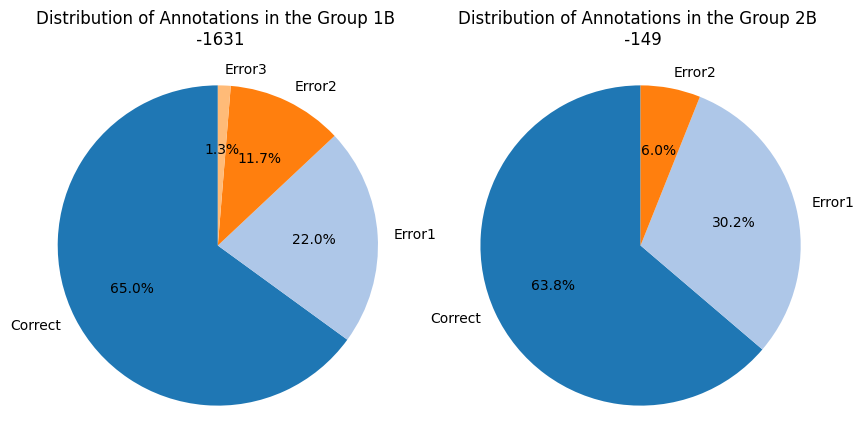

In [75]:
from collections import Counter

# Map numerical values to corresponding names
value_names = {0: 'Correct', 1: 'Error1', 2: 'Error2', 3: 'Error3', 4: 'Incomplete', 5: 'Motionless'}

# Replace numerical values with names
list1B = result1B['CTK']+result1B['ELK']+result1B['RTK']
list2B = result2B['CTK']+result2B['ELK']+result2B['RTK']
named_values_list_1B = [value_names[value] for value in list1B]
named_values_list_2B = [value_names[value] for value in list2B]

# Count the occurrences of each value in the list
value_counts_1B = Counter(named_values_list_1B)
value_counts_2B = Counter(named_values_list_2B)


# Get the values and corresponding counts sorted by label value
labels_1B = [label for label in sorted(value_names.values()) if value_counts_1B[label] > 0]
counts_1B = [value_counts_1B[label] for label in labels_1B]

labels_2B = [label for label in sorted(value_names.values()) if value_counts_2B[label] > 0]
counts_2B = [value_counts_2B[label] for label in labels_2B]

# Define custom colors for the labels
colors = plt.cm.tab20.colors[:len(labels_1B)]  # Adjust based on the number of labels

# Plot a circle chart based on the counts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(counts_1B, labels=labels_1B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Distribution of Annotations in the Group 1B \n -' + str(len(list1B)))

ax[1].pie(counts_2B, labels=labels_2B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Distribution of Annotations in the Group 2B \n -' + str(len(list2B)))

# Display the plot
plt.show()

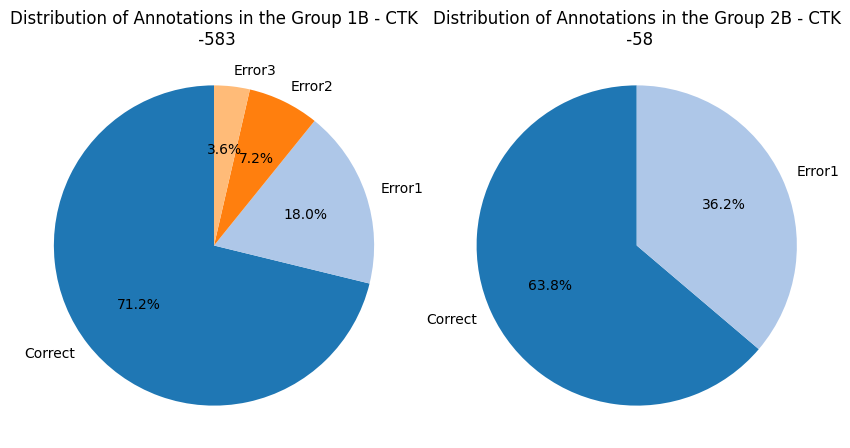

In [76]:
# Replace numerical values with names
list1B = result1B['CTK']
list2B = result2B['CTK']
named_values_list_1B = [value_names[value] for value in list1B]
named_values_list_2B = [value_names[value] for value in list2B]

# Count the occurrences of each value in the list
value_counts_1B = Counter(named_values_list_1B)
value_counts_2B = Counter(named_values_list_2B)

# Get the values and corresponding counts sorted by label value
labels_1B = [label for label in sorted(value_names.values()) if value_counts_1B[label] > 0]
counts_1B = [value_counts_1B[label] for label in labels_1B]

labels_2B = [label for label in sorted(value_names.values()) if value_counts_2B[label] > 0]
counts_2B = [value_counts_2B[label] for label in labels_2B]

# Define custom colors for the labels
colors = plt.cm.tab20.colors[:len(labels_1B)]  # Adjust based on the number of labels

# Plot a circle chart based on the counts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(counts_1B, labels=labels_1B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Distribution of Annotations in the Group 1B - CTK\n -' + str(len(list1B)))

ax[1].pie(counts_2B, labels=labels_2B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Distribution of Annotations in the Group 2B - CTK\n -' + str(len(list2B)))

# Display the plot
plt.show()

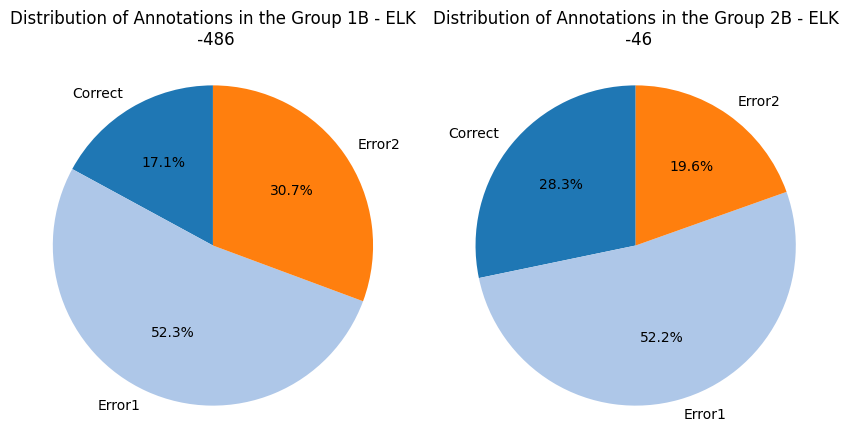

In [77]:
# Replace numerical values with names
list1B = result1B['ELK']
list2B = result2B['ELK']
named_values_list_1B = [value_names[value] for value in list1B]
named_values_list_2B = [value_names[value] for value in list2B]

# Count the occurrences of each value in the list
value_counts_1B = Counter(named_values_list_1B)
value_counts_2B = Counter(named_values_list_2B)

# Get the values and corresponding counts sorted by label value
labels_1B = [label for label in sorted(value_names.values()) if value_counts_1B[label] > 0]
counts_1B = [value_counts_1B[label] for label in labels_1B]

labels_2B = [label for label in sorted(value_names.values()) if value_counts_2B[label] > 0]
counts_2B = [value_counts_2B[label] for label in labels_2B]

# Define custom colors for the labels


# Plot a circle chart based on the counts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(counts_1B, labels=labels_1B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Distribution of Annotations in the Group 1B - ELK\n -' + str(len(list1B)))

ax[1].pie(counts_2B, labels=labels_2B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Distribution of Annotations in the Group 2B - ELK\n -' + str(len(list2B)))

# Display the plot
plt.show()

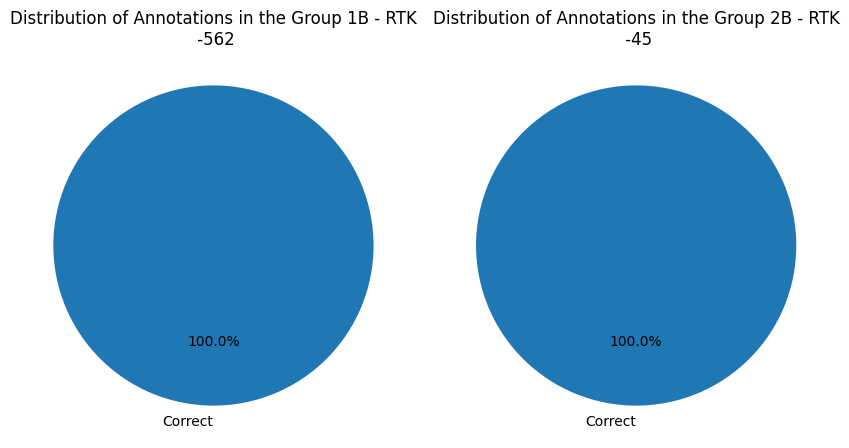

In [78]:
# Replace numerical values with names
list1B = result1B['RTK']
list2B = result2B['RTK']
named_values_list_1B = [value_names[value] for value in list1B]
named_values_list_2B = [value_names[value] for value in list2B]

# Count the occurrences of each value in the list
value_counts_1B = Counter(named_values_list_1B)
value_counts_2B = Counter(named_values_list_2B)

# Get the values and corresponding counts sorted by label value
labels_1B = [label for label in sorted(value_names.values()) if value_counts_1B[label] > 0]
counts_1B = [value_counts_1B[label] for label in labels_1B]

labels_2B = [label for label in sorted(value_names.values()) if value_counts_2B[label] > 0]
counts_2B = [value_counts_2B[label] for label in labels_2B]

# Define custom colors for the labels


# Plot a circle chart based on the counts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pie(counts_1B, labels=labels_1B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Distribution of Annotations in the Group 1B - RTK\n -' + str(len(list1B)))

ax[1].pie(counts_2B, labels=labels_2B, autopct='%1.1f%%', startangle=90,colors=colors)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Distribution of Annotations in the Group 2B - RTK\n -' + str(len(list2B)))

# Display the plot
plt.show()